In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    recall_score
)
from xgboost import XGBClassifier

sns.set_style("whitegrid")

In [64]:
# -------------------------------------------------
# 1. PATHS & BASIC CONFIG
# -------------------------------------------------
raw_data_folder = "../data/raw/"
processed_data_folder = "../data/processed/"
output_folder = "../outputs/"

SAMPLE_SIZE = 50000
RANDOM_STATE = 42
MIN_YEAR = 2015
MAX_YEAR = 2018

def save_fig(filename):
    plt.savefig(os.path.join(output_folder, filename), dpi=300 ,bbox_inches='tight')  
    print(f"Figure saved: {filename}")

In [42]:
# -------------------------------------------------
# 2. LOAD RAW DATA
# -------------------------------------------------
df_raw = pd.read_csv(raw_data_folder + "accepted_2007_to_2018Q4.csv", low_memory=False)
df_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
print("\nUnique loan_status values:")
print(df_raw["loan_status"].dropna().unique())


Unique loan_status values:
['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


In [ ]:
# -------------------------------------------------
# 3. FILTER BY YEAR (2015–2018) + CREATE TARGET
# -------------------------------------------------
GOOD = [
    "Fully Paid",
    "Does not meet the credit policy. Status:Fully Paid"
]
BAD = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Charged Off",
    "Late (31-120 days)",
    "Late (16-30 days)",
    "In Grace Period"
]
df_raw = df_raw[df_raw["issue_d"].notna()].copy()
df_raw["issue_d"] = pd.to_datetime(df_raw["issue_d"], format="%b-%Y")
df_raw = df_raw[(df_raw["issue_d"].dt.year >= MIN_YEAR) &
                (df_raw["issue_d"].dt.year <= MAX_YEAR)]

df_raw = df_raw[df_raw["loan_status"].isin(GOOD + BAD)].copy()

# target: 1 = bad/default, 0 = good/fully paid
df_raw["target"] = df_raw["loan_status"].apply(lambda s: 1 if s in BAD else 0)

print("\nTarget distribution (proportions):")
print(df_raw["target"].value_counts(normalize=True))
print("[Insight] Shows class imbalance between good vs defaulted loans.\n")


Target distribution (proportions):
target
0    0.756728
1    0.243272
Name: proportion, dtype: float64
[Insight] Shows class imbalance between good vs defaulted loans.



In [45]:
# =========================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# =========================================================

df_eda = df_raw.copy()

Figure saved: target_distribution.png


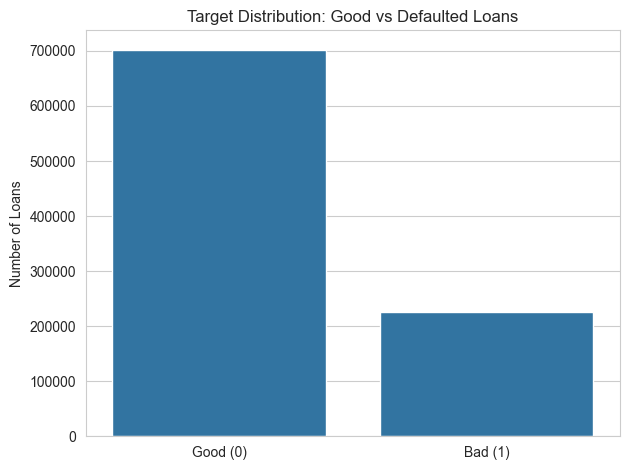

[EDA Insight] If the good bar is much higher, the dataset is imbalanced → we must look at recall and FPR, not just accuracy.



In [65]:

# 4.1 Target distribution plot
target_counts = df_eda["target"].value_counts().sort_index()
plt.figure()
sns.barplot(x=["Good (0)", "Bad (1)"], y=target_counts.values)
plt.title("Target Distribution: Good vs Defaulted Loans")
plt.ylabel("Number of Loans")
plt.tight_layout()
save_fig("target_distribution.png")
plt.show()
print("[EDA Insight] If the good bar is much higher, the dataset is imbalanced → "
      "we must look at recall and FPR, not just accuracy.\n")

Figure saved: loan_amount_distribution.png


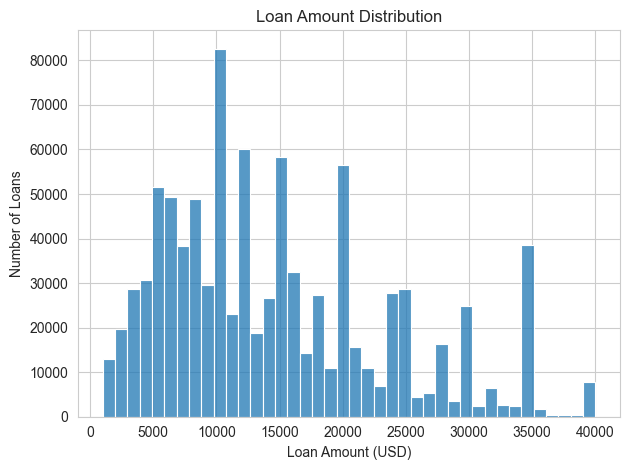

[EDA Insight] Most loans are in a mid-range; very large loans are rarer.



In [66]:

# 4.2 Loan amount distribution
if "loan_amnt" in df_eda.columns:
    plt.figure()
    sns.histplot(df_eda["loan_amnt"], bins=40)
    plt.title("Loan Amount Distribution")
    plt.xlabel("Loan Amount (USD)")
    plt.ylabel("Number of Loans")
    plt.tight_layout()
    save_fig("loan_amount_distribution.png")
    plt.show()
    print("[EDA Insight] Most loans are in a mid-range; very large loans are rarer.\n")

Figure saved: interest_rate_distribution.png


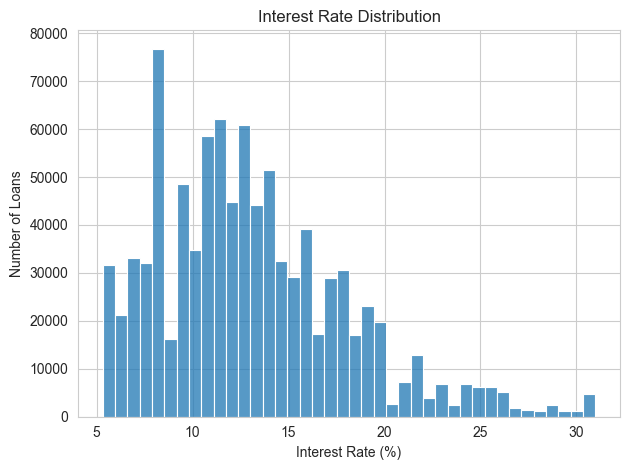

[EDA Insight] Interest rates cluster in a band; higher rates usually correspond to riskier borrowers.



In [67]:
# 4.3 Interest rate distribution
if "int_rate" in df_eda.columns:
    int_rate_clean = df_eda["int_rate"].astype(str).str.replace("%", "", regex=False)
    int_rate_clean = pd.to_numeric(int_rate_clean, errors="coerce")
    plt.figure()
    sns.histplot(int_rate_clean, bins=40)
    plt.title("Interest Rate Distribution")
    plt.xlabel("Interest Rate (%)")
    plt.ylabel("Number of Loans")
    plt.tight_layout()
    save_fig("interest_rate_distribution.png")
    plt.show()
    print("[EDA Insight] Interest rates cluster in a band; higher rates usually "
          "correspond to riskier borrowers.\n")

Figure saved: grade_distribution.png


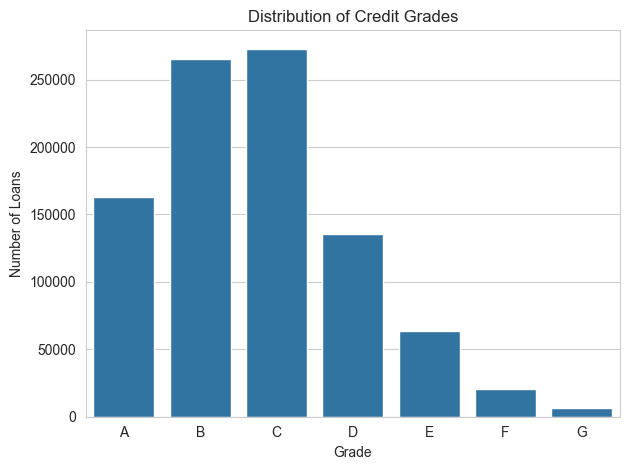

[EDA Insight] Shows how loans are distributed across LC internal credit grades.

Figure saved: default_rate_by_grade.png


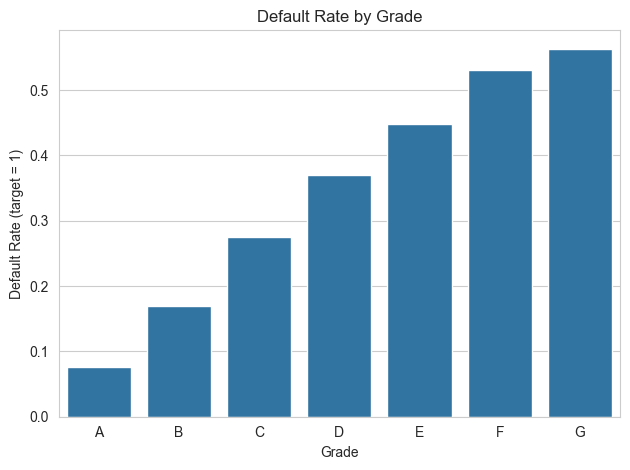

[EDA Insight] Default rate typically increases from A/B to F/G, confirming that grade is a strong predictor of default.



In [69]:
# 4.4 Grade distribution + default rate by grade
if "grade" in df_eda.columns:
    plt.figure()
    sns.countplot(x="grade", data=df_eda,
                  order=sorted(df_eda["grade"].dropna().unique()))
    plt.title("Distribution of Credit Grades")
    plt.xlabel("Grade")
    plt.ylabel("Number of Loans")
    plt.tight_layout()
    save_fig("grade_distribution.png")
    plt.show()
    print("[EDA Insight] Shows how loans are distributed across LC internal credit grades.\n")

    default_rate_by_grade = df_eda.groupby("grade")["target"].mean().sort_index()
    plt.figure()
    sns.barplot(x=default_rate_by_grade.index, y=default_rate_by_grade.values)
    plt.title("Default Rate by Grade")
    plt.xlabel("Grade")
    plt.ylabel("Default Rate (target = 1)")
    plt.tight_layout()
    save_fig("default_rate_by_grade.png")
    plt.show()
    print("[EDA Insight] Default rate typically increases from A/B to F/G, "
          "confirming that grade is a strong predictor of default.\n")

Figure saved: correlation_with_target.png


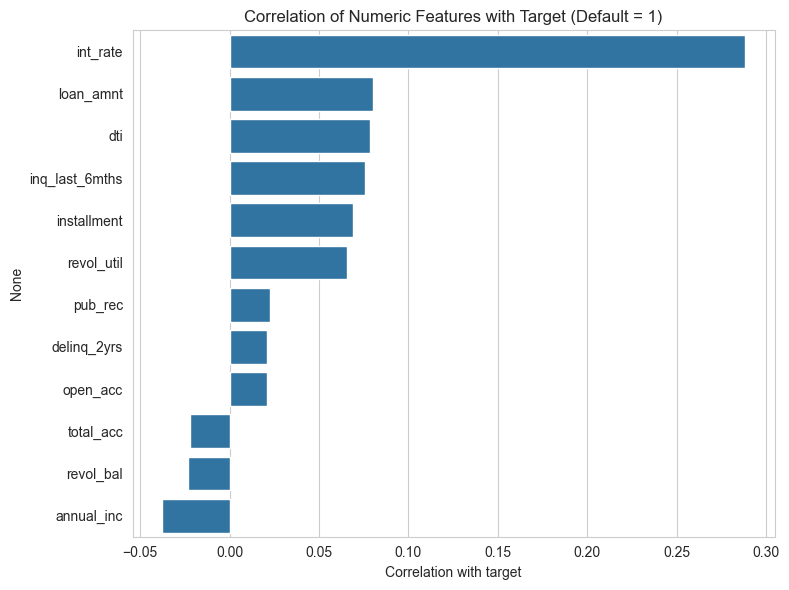


Correlation of numeric features with target:
int_rate          0.288370
loan_amnt         0.080465
dti               0.078712
inq_last_6mths    0.075851
installment       0.068820
revol_util        0.065434
pub_rec           0.022809
delinq_2yrs       0.021076
open_acc          0.021001
total_acc        -0.022080
revol_bal        -0.023188
annual_inc       -0.037880
Name: target, dtype: float64
[EDA Insight] Features with stronger positive correlation (e.g. higher int_rate, higher DTI, higher revol_util) are associated with higher default risk. Negative correlations (e.g. annual_inc) suggest safer borrowers.



In [70]:
# 4.5 Correlation of numeric features with target
numeric_for_corr = [
    "loan_amnt", "int_rate", "installment", "annual_inc", "dti",
    "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec",
    "revol_bal", "revol_util", "total_acc"
]
numeric_for_corr = [c for c in numeric_for_corr if c in df_eda.columns]

corr_df = df_eda[numeric_for_corr + ["target"]].copy()

for col in ["int_rate", "revol_util"]:
    if col in corr_df.columns:
        corr_df[col] = corr_df[col].astype(str).str.replace("%", "", regex=False)
        corr_df[col] = pd.to_numeric(corr_df[col], errors="coerce")

corr_with_target = corr_df.corr()["target"].drop("target").sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title("Correlation of Numeric Features with Target (Default = 1)")
plt.xlabel("Correlation with target")
plt.tight_layout()
save_fig("correlation_with_target.png")
plt.show()

print("\nCorrelation of numeric features with target:")
print(corr_with_target)
print("[EDA Insight] Features with stronger positive correlation (e.g. higher "
      "int_rate, higher DTI, higher revol_util) are associated with higher "
      "default risk. Negative correlations (e.g. annual_inc) suggest safer borrowers.\n")

In [51]:
# =========================================================
# 5. FINAL FEATURE SELECTION (AFTER EDA)
# =========================================================

selected_features = [
    "loan_amnt",       # Loan amount requested
    "term",            # 36 or 60 months
    "int_rate",        # Interest rate (%)
    "installment",     # Monthly installment
    "grade",           # LC internal grade A–G
    "sub_grade",       # More granular grade
    "home_ownership",  # RENT / OWN / MORTGAGE etc.
    "annual_inc",      # Annual income (USD)
    "verification_status",  # Income verified or not
    "purpose",         # Loan purpose
    "addr_state",      # State of borrower
    "dti",             # Debt-to-income ratio
    "delinq_2yrs",     # Delinquencies last 2 years
    "inq_last_6mths",  # Credit inquiries last 6 months
    "open_acc",        # Number of open accounts
    "pub_rec",         # Public records
    "revol_bal",       # Revolving balance
    "revol_util",      # Revolving utilisation (%)
    "total_acc"        # Total number of accounts
]

# keep only those that actually exist in this dataset slice
selected_features = [c for c in selected_features if c in df_raw.columns]
print("\nFinal selected features for modelling:")
print(selected_features)


Final selected features for modelling:
['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']


In [52]:
# =========================================================
# 6. BUILD CLEANED DATASET & SAVE
# =========================================================

df_clean = df_raw[selected_features + ["target"]].copy()

print("\nMissing values BEFORE cleaning (selected features + target):")
print(df_clean.isna().sum())

# Clean percentage columns
for col in ["int_rate", "revol_util"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.replace("%", "", regex=False)
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

print("\nMissing values AFTER percentage cleaning:")
print(df_clean.isna().sum())

# Impute numeric & categorical
num_cols_clean = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_clean = df_clean.select_dtypes(include=["object"]).columns.tolist()

df_clean[num_cols_clean] = df_clean[num_cols_clean].fillna(df_clean[num_cols_clean].median())
df_clean[cat_cols_clean] = df_clean[cat_cols_clean].fillna("Unknown")

print("\nMissing values AFTER imputation:")
print(df_clean.isna().sum())

df_clean.to_csv(processed_data_folder+'processed_dataset.csv', index=False)
print("\n Cleaned dataset saved to:", processed_data_folder+'processed_dataset.csv')


Missing values BEFORE cleaning (selected features + target):
loan_amnt                0
term                     0
int_rate                 0
installment              0
grade                    0
sub_grade                0
home_ownership           0
annual_inc               0
verification_status      0
purpose                  0
addr_state               0
dti                    412
delinq_2yrs              0
inq_last_6mths           1
open_acc                 0
pub_rec                  0
revol_bal                0
revol_util             605
total_acc                0
target                   0
dtype: int64

Missing values AFTER percentage cleaning:
loan_amnt                0
term                     0
int_rate                 0
installment              0
grade                    0
sub_grade                0
home_ownership           0
annual_inc               0
verification_status      0
purpose                  0
addr_state               0
dti                    412
delinq_2yrs       

Figure saved: correlation_matrix_numeric_features.png


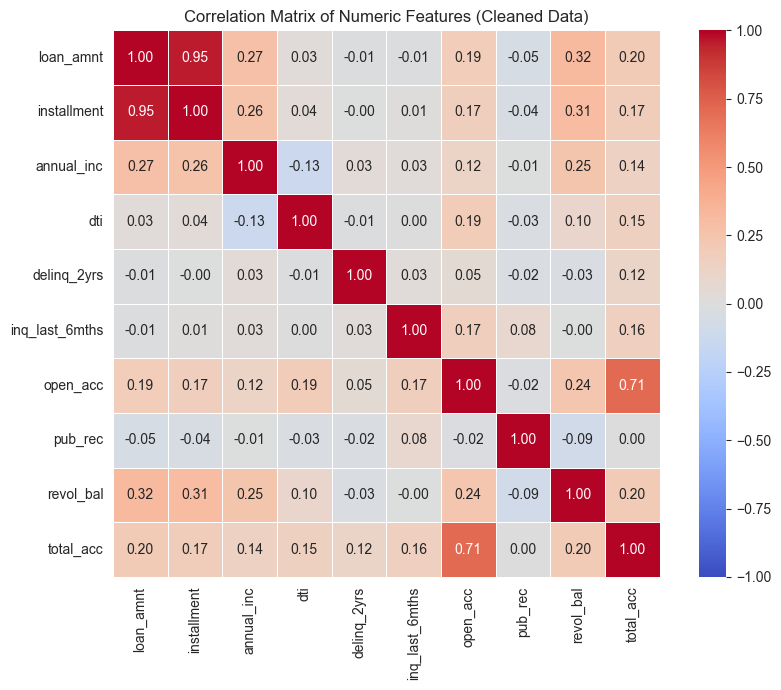

[EDA Insight] Loan amount and installment are strongly correlated (both reflect loan size). Other correlations are moderate, so multicollinearity is not severe.



In [71]:
# =========================================================
# 7. USE CLEANED DATA FOR MODELLING
# =========================================================

df = df_clean.copy()
df.head()

# Numeric correlation heatmap 
numeric_cols_heatmap = [
    "loan_amnt", "installment", "annual_inc", "dti",
    "delinq_2yrs", "inq_last_6mths", "open_acc",
    "pub_rec", "revol_bal", "total_acc"
]
numeric_cols_heatmap = [c for c in numeric_cols_heatmap if c in df.columns]

corr_df2 = df[numeric_cols_heatmap].copy()
if len(corr_df2) > 50000:
    corr_df2 = corr_df2.sample(50000, random_state=RANDOM_STATE)

corr_matrix2 = corr_df2.corr()

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr_matrix2,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True
)
plt.title("Correlation Matrix of Numeric Features (Cleaned Data)")
plt.tight_layout()
save_fig("correlation_matrix_numeric_features.png")
plt.show()
print("[EDA Insight] Loan amount and installment are strongly correlated (both "
      "reflect loan size). Other correlations are moderate, so multicollinearity "
      "is not severe.\n")

In [54]:
# =========================================================
# 8. PREPARE DATA FOR XGBOOST
# =========================================================

df_model = df.copy()

num_cols_model = df_model.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_model = df_model.select_dtypes(include=["object"]).columns.tolist()

df_model[num_cols_model] = df_model[num_cols_model].fillna(df_model[num_cols_model].median())
df_model[cat_cols_model] = df_model[cat_cols_model].fillna("Unknown")


In [55]:
# sample 50,000 rows for speed
df_model = df_model.sample(SAMPLE_SIZE, random_state=RANDOM_STATE).copy()
print("\nUsing sample of 50,000 rows for modelling:", df_model.shape)


Using sample of 50,000 rows for modelling: (50000, 20)


In [56]:
# train-test split
X = df_model.drop("target", axis=1)
y = df_model["target"].values

# one-hot encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)

print("Shape after one-hot encoding:", X.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)

# class imbalance handling
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
scale_pos_weight = n_neg / n_pos
print(f"\nscale_pos_weight (neg/pos) = {scale_pos_weight:.2f}")
print("[Insight] Tells XGBoost to give more weight to the minority class (defaults).\n")

Shape after one-hot encoding: (50000, 118)

Train shape: (40000, 118)
Test shape: (10000, 118)

scale_pos_weight (neg/pos) = 3.11
[Insight] Tells XGBoost to give more weight to the minority class (defaults).



In [57]:

# =========================================================
# 9. TRAIN XGBOOST MODEL
# =========================================================

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
model.fit(X_train, y_train)
print("\nTraining XGBoost model completed.")


Training XGBoost model completed.


In [58]:
# =========================================================
# 10. EVALUATION – CONFUSION MATRIX, RECALL, FPR AT DIFFERENT THRESHOLDS
# =========================================================

y_proba = model.predict_proba(X_test)[:, 1]


--- MODEL PERFORMANCE (Threshold = 0.50) ---
Accuracy: 66.59%  → Overall correctness
Recall (defaults caught): 60.76%
False Positive Rate: 31.54%

Confusion Matrix (Threshold 0.50):
[[5182 2387]
 [ 954 1477]]

Classification Report (0.50):
              precision    recall  f1-score   support

           0     0.8445    0.6846    0.7562      7569
           1     0.3822    0.6076    0.4693      2431

    accuracy                         0.6659     10000
   macro avg     0.6134    0.6461    0.6127     10000
weighted avg     0.7321    0.6659    0.6865     10000

Figure saved: confusion_matrix_threshold_0.50.png


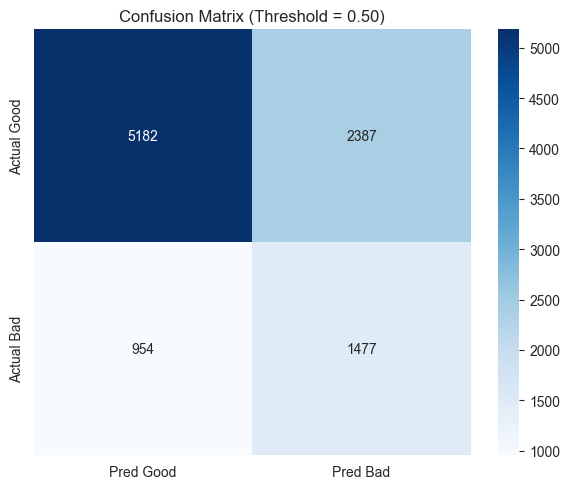

In [72]:
# ---- Threshold 0.50 ----
threshold = 0.50
y_pred_50 = (y_proba >= threshold).astype(int)

cm_50 = confusion_matrix(y_test, y_pred_50)
tn50, fp50, fn50, tp50 = cm_50.ravel()

acc50 = accuracy_score(y_test, y_pred_50)
recall50 = recall_score(y_test, y_pred_50)
fpr50 = fp50 / (fp50 + tn50)

print("\n--- MODEL PERFORMANCE (Threshold = 0.50) ---")
print(f"Accuracy: {acc50*100:.2f}%  → Overall correctness")
print(f"Recall (defaults caught): {recall50*100:.2f}%")
print(f"False Positive Rate: {fpr50*100:.2f}%")

print("\nConfusion Matrix (Threshold 0.50):")
print(cm_50)

print("\nClassification Report (0.50):")
print(classification_report(y_test, y_pred_50, digits=4))

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_50,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred Good', 'Pred Bad'],
    yticklabels=['Actual Good', 'Actual Bad']
)
plt.title("Confusion Matrix (Threshold = 0.50)")
plt.tight_layout()
save_fig("confusion_matrix_threshold_0.50.png")
plt.show()


--- MODEL PERFORMANCE (Threshold = 0.30) ---
Accuracy: 49.16%
Recall (defaults caught): 87.78%
False Positive Rate: 63.24%

Confusion Matrix (Threshold 0.30):
[[2782 4787]
 [ 297 2134]]

Classification Report (0.30):
              precision    recall  f1-score   support

           0     0.9035    0.3676    0.5225      7569
           1     0.3083    0.8778    0.4564      2431

    accuracy                         0.4916     10000
   macro avg     0.6059    0.6227    0.4895     10000
weighted avg     0.7588    0.4916    0.5065     10000

Figure saved: confusion_matrix_threshold_0.30.png


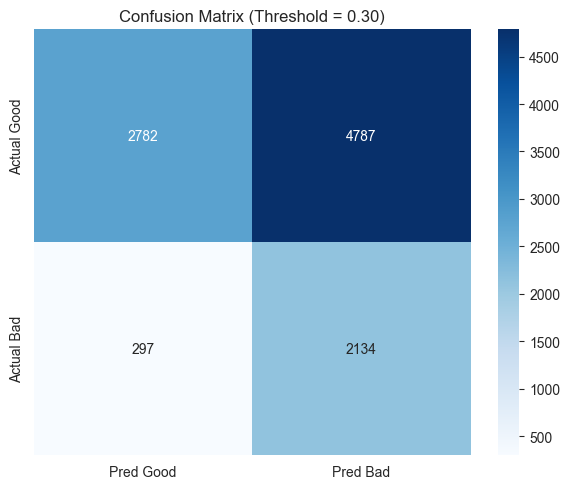

In [73]:
# ---- Threshold 0.30 ----
threshold = 0.30
y_pred_30 = (y_proba >= threshold).astype(int)

cm_30 = confusion_matrix(y_test, y_pred_30)
tn30, fp30, fn30, tp30 = cm_30.ravel()

acc30 = accuracy_score(y_test, y_pred_30)
recall30 = recall_score(y_test, y_pred_30)
fpr30 = fp30 / (fp30 + tn30)

print("\n--- MODEL PERFORMANCE (Threshold = 0.30) ---")
print(f"Accuracy: {acc30*100:.2f}%")
print(f"Recall (defaults caught): {recall30*100:.2f}%")
print(f"False Positive Rate: {fpr30*100:.2f}%")

print("\nConfusion Matrix (Threshold 0.30):")
print(cm_30)

print("\nClassification Report (0.30):")
print(classification_report(y_test, y_pred_30, digits=4))

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_30,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred Good', 'Pred Bad'],
    yticklabels=['Actual Good', 'Actual Bad']
)
plt.title("Confusion Matrix (Threshold = 0.30)")
plt.tight_layout()
save_fig("confusion_matrix_threshold_0.30.png")
plt.show()

Figure saved: cost_analysis_by_threshold.png


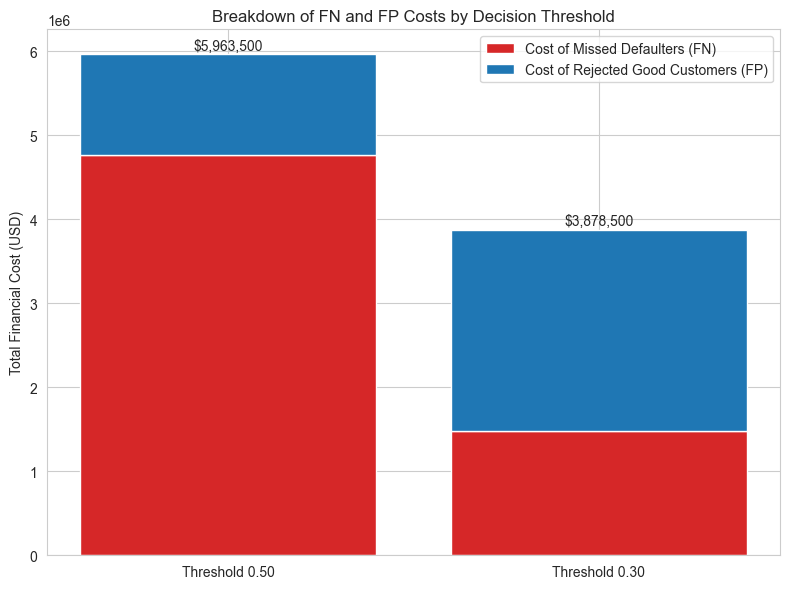


 Insight: Threshold 0.30 reduces costly missed defaulters and gives the lowest total financial loss, making it the optimal business decision.


In [74]:

# =========================================================
# 11. COST ANALYSIS – COST OF DEFAULT VS LOST OPPORTUNITY
# =========================================================

fn_cost_50 = fn50 * COST_FN
fp_cost_50 = fp50 * COST_FP

fn_cost_30 = fn30 * COST_FN
fp_cost_30 = fp30 * COST_FP

labels = ["Threshold 0.50", "Threshold 0.30"]
fn_costs = [fn_cost_50, fn_cost_30]
fp_costs = [fp_cost_50, fp_cost_30]

plt.figure(figsize=(8, 6))

# Stack FP on top of FN
plt.bar(labels, fn_costs, label="Cost of Missed Defaulters (FN)", color="#d62728")
plt.bar(labels, fp_costs, bottom=fn_costs, label="Cost of Rejected Good Customers (FP)", color="#1f77b4")

# Add total labels
for i, total in enumerate([cost_50, cost_30]):
    plt.text(i, total + 60000, f"${total:,.0f}", ha="center")

plt.ylabel("Total Financial Cost (USD)")
plt.title("Breakdown of FN and FP Costs by Decision Threshold")
plt.legend()
plt.tight_layout()
save_fig("cost_analysis_by_threshold.png")
plt.show()
print("\n Insight: Threshold 0.30 reduces costly missed defaulters and gives the lowest total financial loss, making it the optimal business decision.")



--- AUC / ROC ---
AUC: 0.708 (70.84%)
Interpretation: the model ranks a random defaulted borrower as riskier than a random non-defaulted borrower about 70.8% of the time.

Figure saved: roc_curve_xgboost.png


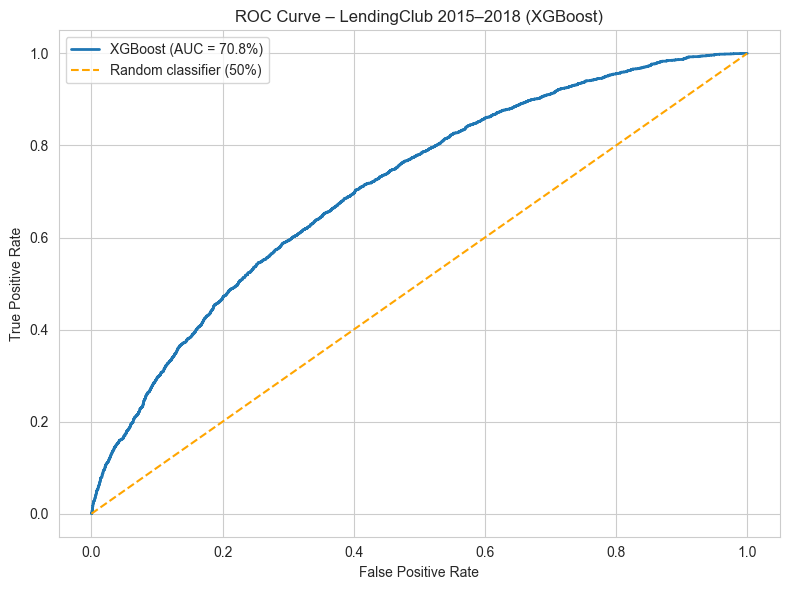

In [75]:

# =========================================================
# 12. ROC CURVE + AUC
# =========================================================

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_value = roc_auc_score(y_test, y_proba)
auc_percent = auc_value * 100

print("\n--- AUC / ROC ---")
print(f"AUC: {auc_value:.3f} ({auc_percent:.2f}%)")
print("Interpretation: the model ranks a random defaulted borrower as riskier "
      f"than a random non-defaulted borrower about {auc_percent:.1f}% of the time.\n")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_percent:.1f}%)", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", label="Random classifier (50%)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – LendingClub 2015–2018 (XGBoost)")
plt.legend()
plt.tight_layout()
save_fig("roc_curve_xgboost.png")
plt.show()


Top 20 features by importance:
                     feature  importance
1                   int_rate    0.046226
12           term_ 60 months    0.034475
53   home_ownership_MORTGAGE    0.016665
55       home_ownership_RENT    0.014622
114            addr_state_WA    0.013450
20              sub_grade_A3    0.013234
47              sub_grade_F5    0.012995
15                   grade_D    0.012788
22              sub_grade_A5    0.012271
13                   grade_B    0.012243
104            addr_state_OR    0.011474
92             addr_state_MS    0.011255
18                   grade_G    0.010477
87             addr_state_MD    0.009983
19              sub_grade_A2    0.009674
81             addr_state_IL    0.009591
68          purpose_vacation    0.009519
45              sub_grade_F3    0.009371
107            addr_state_SC    0.009173
4                        dti    0.009170
Figure saved: top_20_feature_importances.png


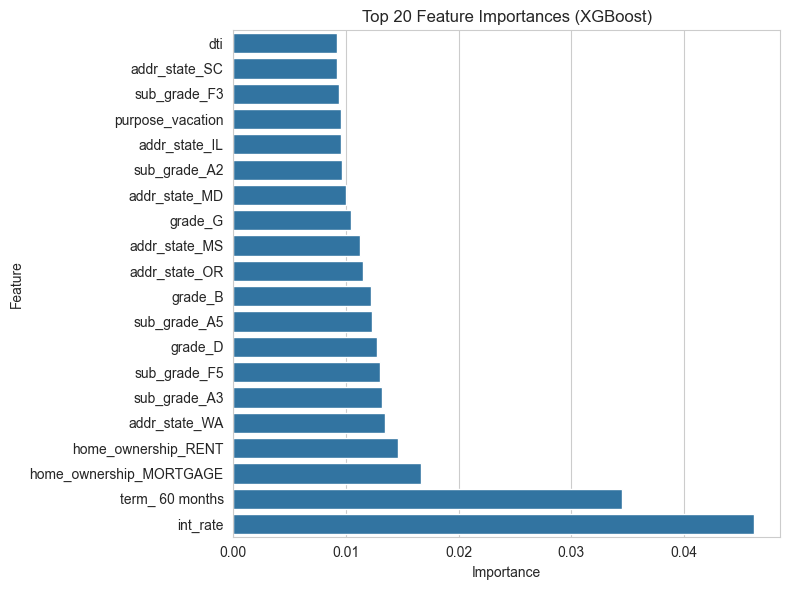

[Insight] These are the main drivers of the model’s risk score (typically grade/sub_grade, int_rate, DTI, utilisation, etc.).



In [76]:

# =========================================================
# 13. FEATURE IMPORTANCE
# =========================================================

importance = model.feature_importances_
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

print("\nTop 20 features by importance:")
print(importance_df.head(20))

plt.figure(figsize=(8, 6))
top_n = 20
sns.barplot(
    x="importance",
    y="feature",
    data=importance_df.head(top_n).sort_values("importance", ascending=True)
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
save_fig("top_20_feature_importances.png")
plt.show()
print("[Insight] These are the main drivers of the model’s risk score "
      "(typically grade/sub_grade, int_rate, DTI, utilisation, etc.).\n")
